In [1]:
import os
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [2]:
import numpy as np

from matplotlib import pyplot as plt

import json

from tqdm import tqdm

import utils

from modules import helpers, fitting

import importlib
importlib.reload(utils)
importlib.reload(helpers)
importlib.reload(fitting)

helpers.set_plot_configs()

In [3]:
calibration = utils.MCACalibration('data/2025-03-04/Calibration_recoil_na_0304.Spe',
                                   'data/2025-03-04/Calibration_recoil_ba_0304.Spe',
                                   kernel_bw=5,cs_137_approx_line_bin=1800,)

/Users/vinhtran/Data/MIT Classes/Spring 2025/8.13/mit-jlab-sp25/modules/fitting.py:56: RuntimeWarning: invalid value encountered in sqrt
  e_params = np.sqrt(np.diagonal(cov))


In [4]:
DataReader = utils.MCAData()

def show_calibration_spectrum(ax,sub_ax,isotope='na',file_base=['data/2025-03-04/Calibration_recoil_','_0304.Spe'],
                              kernel_bw=5,cs_137_approx_line_bin=1800,
                              ylim=[0,8000],xlabel=None):
    # Process data
    bins, counts, _, _ = DataReader._read_data(file_base[0]+isotope+file_base[1])
    normalizing_factor = np.sum(counts) * (bins[1] - bins[0])
    kde_bins, kdes, kdes_err = DataReader._kde_smooth_data(bins, counts, bw=kernel_bw)
    peaks_idx, valleys_idx = DataReader._find_peaks_and_valleys(kde_bins, kdes, kdes_err)

    calibration = utils.MCACalibration(file_base[0]+'na'+file_base[1],file_base[0]+'ba'+file_base[1],
                                       kernel_bw=kernel_bw,cs_137_approx_line_bin=cs_137_approx_line_bin,)

    # Plot spectrum
    ax.plot(bins, counts, color='darkcyan', label='Spectrum' if isotope == 'na' else None)
    ax.plot(kde_bins, kdes*normalizing_factor, color='darkblue', ls='--', label='KDE' if isotope == 'na' else None)

    # for peak_idx in peaks_idx:
    #     ax.axvline(kde_bins[peak_idx], color='darkblue', ls='--', dashes=(1.5,2), lw=2)
    # for valley_idx in valleys_idx:
    #     ax.axvline(kde_bins[valley_idx], color='chocolate', ls='--', dashes=(1.5,2), lw=2)

    if isotope == 'na':
        peaks_mu = list(calibration.na_22_peak_mu)
        peaks_fitting_bins = [calibration.na_22_fitting_bins]
        peaks_fitted_counts = [calibration.na_22_fitted_counts]
    if isotope == 'ba':
        peaks_mu = []
        for mus in calibration.ba_133_peaks_mu:
            peaks_mu += list(mus)
        peaks_mu += list(calibration.cs_137_peak_mu)
        peaks_fitting_bins = calibration.ba_133_fitting_bins + [calibration.cs_137_fitting_bins]
        peaks_fitted_counts = calibration.ba_133_fitted_counts + [calibration.cs_137_fitted_counts]

    for i, (fitting_bins, fitted_counts) in enumerate(zip(peaks_fitting_bins, peaks_fitted_counts)):
        ax.plot(fitting_bins,fitted_counts, color='maroon', ls='-', lw=3, label='Peak Fits' if isotope == 'na' and not i else None)
        # ax.axvline(fitting_bins[0], color='maroon', ls='--', lw=2)
        # ax.axvline(fitting_bins[-1], color='maroon', ls='--', lw=2)

    for mu in peaks_mu:
        ax.axvline(mu, color='maroon', ls='--', lw=2)
        print(mu)

    ax.set_xlim(0,2047)
    ax.set_ylim(ylim)

    if isotope == 'ba':
        ax.set_xlabel('Channel')
    ax.set_ylabel(xlabel)

    ax.legend(loc='upper left', frameon=False, fontsize=22, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)
    
    # Plot energy calibration
    if isotope == 'ba':
        sub_ax.patch.set_alpha(0.9)

        sub_ax.scatter(calibration.calib_bins, calibration.calib_energies, marker='+', s=100, color='maroon', zorder=-1)

        bins_dense = np.linspace(0, 1800, 1000)
        sub_ax.plot(bins_dense, calibration.energy_scaler*bins_dense + calibration.energy_offset, color='black', ls='--',zorder=-2,label='Energy Calibration')

        print('scaler:',calibration.energy_scaler,calibration.energy_scaler_err)
        print('offset:',calibration.energy_offset,calibration.energy_offset_err)

        for i in range(300):
            scaler = np.random.normal(calibration.energy_scaler,calibration.energy_scaler_err)
            offset = np.random.normal(calibration.energy_offset,calibration.energy_offset_err)

            sub_ax.plot(bins_dense, scaler*bins_dense + offset, color='grey', alpha=0.01, zorder=-3)

        sub_ax.set_xlabel('Channel', fontsize=20)
        sub_ax.set_ylabel('Energy [keV]', fontsize=20)

        sub_ax.tick_params(axis='both', labelsize=20)

        sub_ax.set_xlim(0, 1800)
        sub_ax.set_ylim(0, 700)

        sub_ax.set_xticks([0,500,1000,1500])
        sub_ax.set_yticks([0,200,400,600])

        sub_ax.legend(loc='upper left', frameon=False, fontsize=20, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

        # sub_ax.yaxis.tick_right()
        # sub_ax.yaxis.set_label_position("right")

1347.2524260208718
154.7466678585634
218.14411839926314
218.17109348992224
438.7421596371533
760.1198375838304
815.8778689223542
949.4465534218577
1697.972640982374
scaler: 0.38995371945705426 0.013803276906616712
offset: -10.545637452852462 6.228849855268303


/var/folders/_n/k8j9__0s4x1b10rq7h7zj1bc0000gq/T/ipykernel_11876/3600002910.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', frameon=False, fontsize=22, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)
/var/folders/_n/k8j9__0s4x1b10rq7h7zj1bc0000gq/T/ipykernel_11876/289676947.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


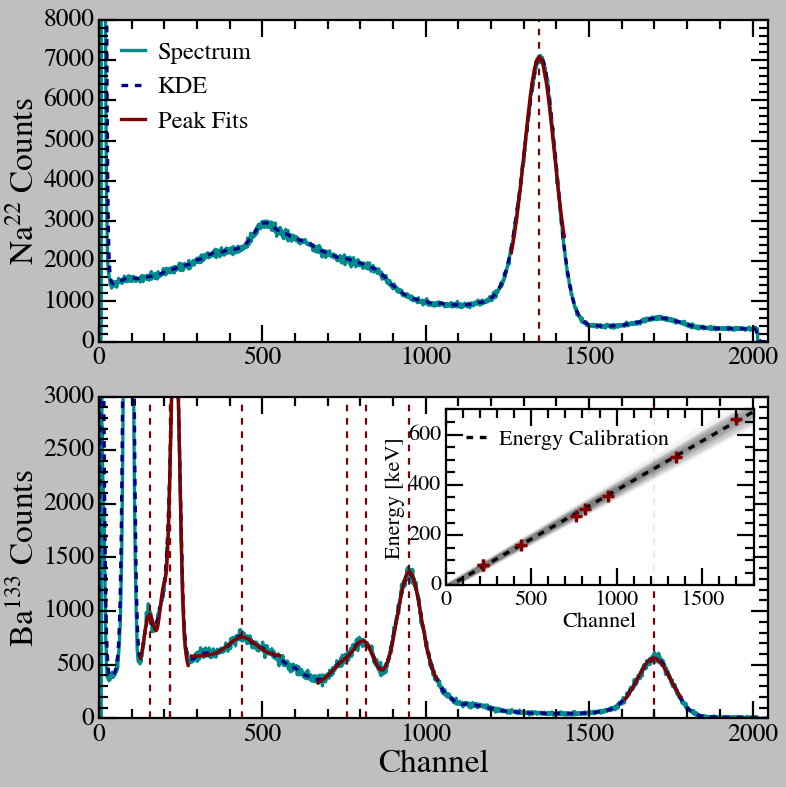

In [5]:
ylims = {
    'na': [0,8000],
    'ba': [0,3000],
}

xlabels = {
    'na': r'Na$^{22}$ Counts',
    'ba': r'Ba$^{133}$ Counts',
}

fig, axs = plt.subplots(2,1,figsize=(10, 10))

# fig.add_subplot((0.15,0.75,0.35,0.2))
# fig.add_subplot((0.60,0.28,0.35,0.2))

sub_ax = fig.add_subplot((0.565,0.26,0.385,0.22))

for i, isotope in enumerate(['na','ba']):
    show_calibration_spectrum(axs[i],sub_ax=sub_ax,
                              isotope=isotope,
                              ylim=ylims[isotope],
                              xlabel=xlabels[isotope])

plt.tight_layout()
plt.savefig('report/Figures/energy_calibration.png')

plt.show()

In [6]:
if False:
    ylims = {
        'na': [0,8000],
        'ba': [0,3000],
    }

    xlabels = {
        'na': r'Na$^{22}$ Counts',
        'ba': r'Ba$^{133}$ Counts',
    }

    fig, axs = plt.subplots(2,1,figsize=(10, 10))


    sub_ax = fig.add_subplot((0.565,0.26,0.385,0.22))

    for i, isotope in enumerate(['na','ba']):
        show_calibration_spectrum(axs[i],sub_ax=sub_ax,
                                isotope=isotope,
                                file_base=['data/2025-03-11/Calibration_attenuation_','_0311.Spe'],
                                kernel_bw=5,cs_137_approx_line_bin=False,
                                ylim=ylims[isotope],
                                xlabel=xlabels[isotope])

    plt.tight_layout()

    plt.show()

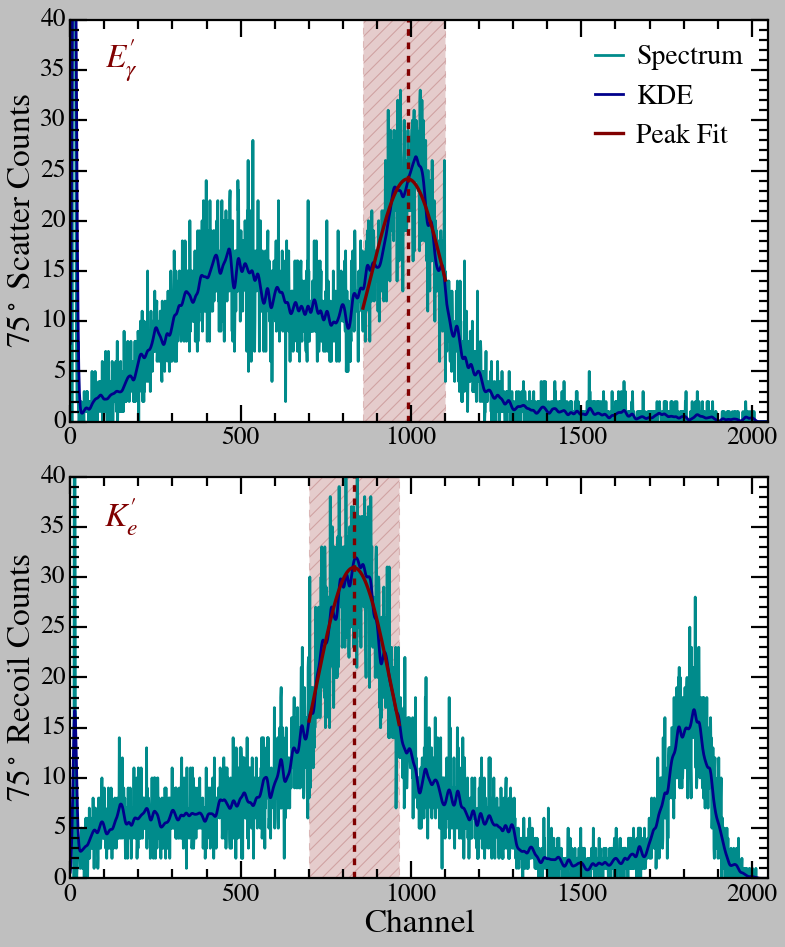

In [63]:
fig, axs = plt.subplots(2,1,figsize=(10, 12))

# Scatter
ax = axs[0]

DataReader = utils.MCAData()

bins, counts, _, _ = DataReader._read_data('data/2025-03-06/scatter_75_0306.Spe')
count_normalizing_factor = np.sum(counts) * (bins[1] - bins[0])
kde_bins, kdes, kdes_err = DataReader._kde_smooth_data(bins, counts, bw=5)
peaks_idx, valleys_idx = DataReader._find_peaks_and_valleys(kde_bins, kdes, kdes_err)

approx_peak_idx = peaks_idx[0]
approx_peak_bin = bins[approx_peak_idx]
approx_peak_kde = kdes[approx_peak_idx]

lower_idx, upper_idx = DataReader._get_fitting_boundaries(bins,kdes,peaks_idx,valleys_idx,
                                                            approx_peak_bin,approx_peak_bin,
                                                            threshold=approx_peak_kde/2,threshold_ratio=1,
                                                            outward=True)

compton = utils.MCACompton(data_base='75_0306.Spe',data_dir='data/2025-03-06/',)

peak_mu_count, peak_mu_count_err, peak_sigma_count, peak_sigma_count_err, \
peak_mu_energy, peak_mu_energy_err, peak_sigma_energy, peak_sigma_count_err, \
peak_fwhm_rate, peak_fwhm_rate_err, _, fitting_bins, fitted_counts, peak_mu_bin_deviation = compton._peak_analysis('scatter')



ax.plot(bins, counts, color='darkcyan', label='Spectrum', lw=2.5)
ax.plot(kde_bins, kdes*count_normalizing_factor, color='darkblue', label='KDE', lw=2.5)

ax.plot(fitting_bins, fitted_counts, color='maroon', ls='-', label='Peak Fit')
ax.axvline(peak_mu_count, color='maroon', ls='--')
ax.axvspan(bins[lower_idx], bins[upper_idx], color='maroon', ls='--', alpha=0.2, hatch='//')

ax.set_xlim(0, 2048)
ax.set_ylim(0, 40)
ax.set_ylabel(r'$75^\circ$ Scatter Counts')

ax.legend(loc='upper right', frameon=False, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

ax.text(150,36,r'$E_\gamma^\prime$', fontsize=30, color='maroon', ha='center', va='center')

# Recoil
ax = axs[1]

DataReader = utils.MCAData()

bins, counts, _, _ = DataReader._read_data('data/2025-03-06/recoil_75_0306.Spe')
count_normalizing_factor = np.sum(counts) * (bins[1] - bins[0])
kde_bins, kdes, kdes_err = DataReader._kde_smooth_data(bins, counts, bw=5)
peaks_idx, valleys_idx = DataReader._find_peaks_and_valleys(kde_bins, kdes, kdes_err)

approx_peak_idx = peaks_idx[0]
approx_peak_bin = bins[approx_peak_idx]
approx_peak_kde = kdes[approx_peak_idx]

lower_idx, upper_idx = DataReader._get_fitting_boundaries(bins,kdes,peaks_idx,valleys_idx,
                                                            approx_peak_bin,approx_peak_bin,
                                                            threshold=approx_peak_kde/2,threshold_ratio=1,
                                                            outward=True)

compton = utils.MCACompton(data_base='75_0306.Spe',data_dir='data/2025-03-06/',)

peak_mu_count, peak_mu_count_err, peak_sigma_count, peak_sigma_count_err, \
peak_mu_energy, peak_mu_energy_err, peak_sigma_energy, peak_sigma_count_err, \
peak_fwhm_rate, peak_fwhm_rate_err, _, fitting_bins, fitted_counts, peak_mu_bin_deviation = compton._peak_analysis('recoil')

ax.plot(bins, counts, color='darkcyan', label='Spectrum', lw=2.5)
ax.plot(kde_bins, kdes*count_normalizing_factor, color='darkblue', label='KDE', lw=2.5)

ax.plot(fitting_bins, fitted_counts, color='maroon', ls='-', label='Peak Fit')
ax.axvline(peak_mu_count, color='maroon', ls='--')
ax.axvspan(bins[lower_idx], bins[upper_idx], color='maroon', ls='--', alpha=0.2, hatch='//')

ax.set_xlim(0, 2048)
ax.set_ylim(0, 40)
ax.set_xlabel('Channel')
ax.set_ylabel(r'$75^\circ$ Recoil Counts')

ax.text(150,36,r'$K_e^\prime$', fontsize=30, color='maroon', ha='center', va='center')

plt.tight_layout()
plt.savefig('report/Figures/example_spectrum.png')
plt.show()

In [ ]:
compton_metadata = {
    0 : ['0_0304.Spe','data/2025-03-04'],
    30 : ['30_0304.Spe','data/2025-03-04'],
    60 : ['60_0304.Spe','data/2025-03-04'],
    90 : ['90_0304.Spe','data/2025-03-04'],
    120 : ['120_0304.Spe','data/2025-03-04'],

    15 : ['15_0306.Spe','data/2025-03-06'],
    45 : ['45_0306.Spe','data/2025-03-06'],
    75 : ['75_0306.Spe','data/2025-03-06'],
    105 : ['105_0306.Spe','data/2025-03-06'],
    135 : ['135_0306.Spe','data/2025-03-06'],
}

In [ ]:
for angle in compton_metadata:
    data_file = os.path.join(compton_metadata[angle][1],'scatter_'+compton_metadata[angle][0])
    
    bins, counts, counting_time, total_time = DataReader._read_data(data_file)

    print(f'{angle:.0f} & {counting_time:.0f} & {total_time:.0f} & {compton_metadata[angle][1][5:]} \\\\')

0 & 964 & 1012 & 2025-03-04 \\
30 & 1194 & 1224 & 2025-03-04 \\
60 & 1619 & 1658 & 2025-03-04 \\
90 & 1856 & 1900 & 2025-03-04 \\
120 & 1706 & 1736 & 2025-03-04 \\
15 & 1354 & 1522 & 2025-03-06 \\
45 & 1333 & 1455 & 2025-03-06 \\
75 & 1954 & 2058 & 2025-03-06 \\
105 & 1645 & 1727 & 2025-03-06 \\
135 & 1341 & 1431 & 2025-03-06 \\


In [ ]:
class ComptonMeasurements:
    detector_species = {
        'recoil' : 'electron',
        'scatter' : 'photon',
        'attenuation' : 'photon',
    }

    original_peak_mu_energy = 661.7
    electron_rest_energy = 511

    def __init__(self,metadata=compton_metadata,
                 fields=['mu_energy','sigma_energy','fwhm_rate'],
                 detectors=['recoil','scatter'],
                 material_thickness=None,
                 peak_idx=0,thredshold_ratio=1/2):
        self.metadata = metadata
        self.fields = fields
        self.detectors = detectors

        self._initialize_attributes()

        self.angles = np.array([])
        for angle, [data_base,data_dir] in tqdm(metadata.items()):
            self.angles = np.append(self.angles,angle)
            self._get_single_measurement(data_base,data_dir,peak_idx,thredshold_ratio)

        self._sort_measurements()

        if material_thickness is not None:
            self.thickness = np.array([material_thickness[angle] for angle in self.angles])
            self.__delattr__('angles')

        if 'recoil' in detectors or 'scatter' in detectors:
            self.original_peak_width_ratio = self.original_peak_width_ratios.mean()
            self.original_peak_width_ratio_err = self.original_peak_width_ratios.std()
        self.__delattr__('original_peak_width_ratios')

    def _initialize_attributes(self):
        for detector in self.detectors:
            for field in self.fields:
                stats = ['','_err']
                if field == 'fwhm_rate':
                    stats += ['_sys_err']
                for stat in stats:
                    self.__setattr__(self.detector_species[detector]+'_'+field+stat,np.array([]))

        self.original_peak_width_ratios = np.array([])

    def _get_single_measurement(self,data_base,data_dir,peak_idx,thredshold_ratio):
        compton_data = utils.MCACompton(data_base=data_base,data_dir=data_dir,
                                        detectors=self.detectors,
                                        peak_idx=peak_idx,thredshold_ratio=thredshold_ratio)

        for detector in self.detectors:
            for field in self.fields:
                stats = ['','_err']
                if field == 'fwhm_rate':
                    stats += ['_sys_err']
                for stat in stats:
                    self.__setattr__(self.detector_species[detector]+'_'+field+stat,
                                     np.append(self.__getattribute__(self.detector_species[detector]+'_'+field+stat),
                                               compton_data.__getattribute__(detector+'_peak_'+field+stat)))
                    
            if detector == 'recoil':
                self.original_peak_width_ratios = np.append(self.original_peak_width_ratios,compton_data.original_peak_width_ratio)

    def _sort_measurements(self):
        sort_idx = np.argsort(self.angles)

        for detector in self.detectors:
            for field in self.fields:
                stats = ['','_err']
                if field == 'fwhm_rate':
                    stats += ['_sys_err']

                for stat in stats:
                    self.__setattr__(self.detector_species[detector]+'_'+field+stat,
                                     self.__getattribute__(self.detector_species[detector]+'_'+field+stat)[sort_idx])

        self.angles = self.angles[sort_idx]

In [ ]:
compton_measurements = ComptonMeasurements()

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


In [ ]:
class ComptonScatteringFitter(fitting.BaseFitter):
    p = 661.7
    me = 511

    def __init__(self,thetas,energies,energies_err):
        super().__init__(thetas,energies,energies_err)

    def _get_initial_guess(self):
        return [0]
    
    def _get_model(self,x,params):
        theta0 = params[0]
        return self.p / (1 + self.p / self.me * (1 - np.cos(np.deg2rad(x-theta0))))

In [ ]:
def show_total_energy(compton_measurements,ax):
    total_mu_energy = compton_measurements.electron_mu_energy + compton_measurements.photon_mu_energy
    total_mu_energy_err = np.sqrt(compton_measurements.electron_mu_energy_err**2 + compton_measurements.photon_mu_energy_err**2)

    ax.errorbar(compton_measurements.angles, total_mu_energy, yerr=total_mu_energy_err, 
            fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1.5, color='darkblue', zorder=-1)

    ax.axhline(661.7, color='darkcyan', linestyle='--', zorder=-2)

    ax.set_xlim(-5, 140)
    ax.set_ylim(600,700)

    ax.set_ylabel(r'$E_\gamma^\prime + K_e^\prime$ [keV]')

def show_scatter_and_recoil_energy(compton_measurements,ax):
    ax.errorbar(compton_measurements.angles, compton_measurements.photon_mu_energy, yerr=compton_measurements.photon_mu_energy_err,
                fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1.5, 
                color='maroon',label=r'$E_\gamma^\prime$')
    ax.errorbar(compton_measurements.angles, compton_measurements.electron_mu_energy, yerr=compton_measurements.electron_mu_energy_err,
                fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1.5, 
                color='chocolate',label=r'$K_e^\prime$')
    
    compton_fitter = ComptonScatteringFitter(compton_measurements.angles,661.7-compton_measurements.electron_mu_energy,compton_measurements.electron_mu_energy_err)
    fitting_result = compton_fitter.fit()
    print(fitting_result)
    dense_angles, dense_photon_energies = compton_fitter.model_interpolation(params=fitting_result['params'])
    
    ax.plot(dense_angles, dense_photon_energies, color='maroon', linestyle='--')
    ax.plot(dense_angles, compton_fitter.p - dense_photon_energies, color='chocolate', linestyle='--')

    ax.set_xlim(-5, 140)
    ax.set_ylim(0, 700)

    ax.set_xlabel(r'$\theta$ [deg]')
    ax.set_ylabel(r'$E$ [keV]',labelpad=10)

    ax.legend(loc='center left', frameon=False, fontsize=22, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

    ax_extra = ax.twinx()
    ax_extra.errorbar([1000], [1000], yerr=[1000], 
                      fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1.5, 
                      color='black', label='Experimental Data')
    ax_extra.plot([1000], [1000], color='black', linestyle='--', zorder=-2, label='Compton Prediction')
    ax_extra.legend(loc='upper right', frameon=False, fontsize=22, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)
    ax_extra.set_yticks([])
    ax.tick_params(axis='both', which='both',direction='in',top=True,right=True)

{'params': array([2.56374559]), 'e_params': array([0.70833692]), 'chisqr': 61.27509530636054, 'reduced_chisqr': 6.808343922928949, 'alpha': 7.608562668792729e-10, 'cov': array([[0.5017412]]), 'success': True, 'message': '`ftol` termination condition is satisfied.'}


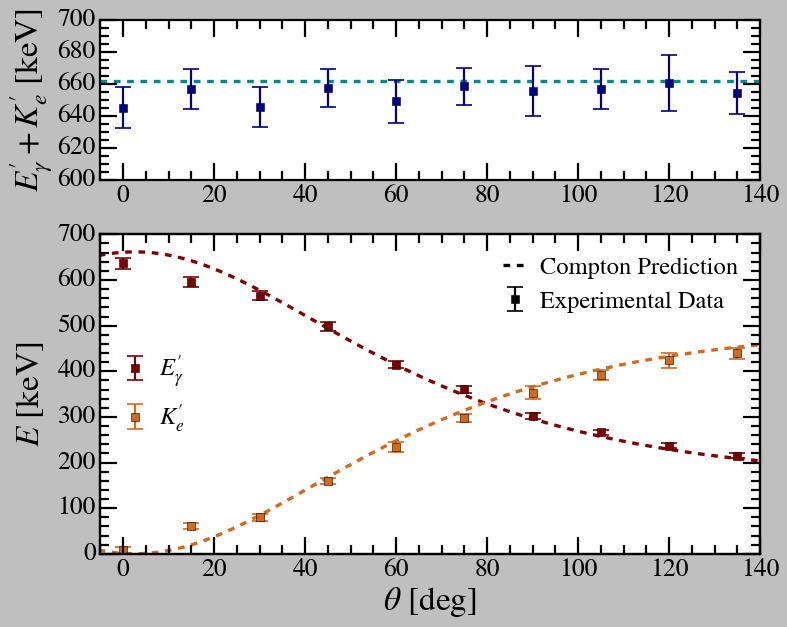

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(10,8),height_ratios=[0.5,1])

show_total_energy(compton_measurements,axs[0])
show_scatter_and_recoil_energy(compton_measurements,axs[1])

plt.tight_layout()
plt.savefig('report/Figures/energy_angle_dependency.png')

plt.show()

In [ ]:
class ThompsonScatteringFitter(fitting.BaseFitter):
    def __init__(self,thetas,scattering_rates,scattering_rates_err,theta0):
        super().__init__(thetas,scattering_rates,scattering_rates_err)

        self.theta0 = theta0

    def _get_initial_guess(self):
        return [1]
    
    def _get_model(self,x,params):
        I = params[0]
        return I * (1 + np.cos(np.deg2rad(x-self.theta0))**2)

class KleinNishinaScatteringFitter(fitting.BaseFitter):
    p = 661.7
    me = 511

    def __init__(self,thetas,scattering_rates,scattering_rates_err,theta0):
        super().__init__(thetas,scattering_rates,scattering_rates_err)
        
        self.theta0 = theta0

    def _get_initial_guess(self):
        return [1]
    
    def _get_model(self,x,params):
        I = params[0]
        lambda_lambdap = 1 / (1 + self.p/self.me*(1 - np.cos(np.deg2rad(x-self.theta0))))

        return I * lambda_lambdap**2 * (lambda_lambdap + 1/lambda_lambdap - np.sin(np.deg2rad(x-self.theta0))**2)

In [ ]:
def show_scattering_rate(compton_measurements,ax):
    compton_fitter = ComptonScatteringFitter(compton_measurements.angles,661.7-compton_measurements.electron_mu_energy,compton_measurements.electron_mu_energy_err)
    compton_fitting_result = compton_fitter.fit()
    theta0 = compton_fitting_result['params'][0]
    theta0_err = compton_fitting_result['e_params'][0]

    ax.errorbar(compton_measurements.angles-theta0, compton_measurements.electron_fwhm_rate, 
                yerr=compton_measurements.electron_fwhm_rate_err,
                fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1.5, 
                color='maroon',label=r'$\Gamma_e^\prime$')
    
    ax.errorbar(compton_measurements.angles-theta0, compton_measurements.electron_fwhm_rate, 
                yerr=compton_measurements.electron_fwhm_rate_sys_err,
                fmt=' s', markersize=0.5, elinewidth=5, capsize=0, capthick=0,
                color='maroon',alpha=0.5)

    fitting_idx = np.arange(compton_measurements.angles.size)[1:]
    
    def scatter_rate_fitter(fitter_clase,color,ls,label,zorder):
        fitter = fitter_clase(compton_measurements.angles[fitting_idx]-theta0,compton_measurements.electron_fwhm_rate[fitting_idx],compton_measurements.electron_fwhm_rate_err[fitting_idx],theta0=theta0)
        result = fitter.fit()
        print(result)
        reduced_chisqr = result["reduced_chisqr"]
        dense_angles, dense_scattering_rates = fitter.model_interpolation(params=result['params'])

        ax.plot(dense_angles, dense_scattering_rates, color=color, ls=ls, label=f'{label}', zorder=zorder, alpha=0.8)

    scatter_rate_fitter(KleinNishinaScatteringFitter,color='darkslategray',ls='-',label='Klein-Nishina',zorder=-2)
    scatter_rate_fitter(ThompsonScatteringFitter,color='darkslategray',ls='--',label='Thompson',zorder=-3)
    
    ax.set_xlim(-5, 140)
    ax.set_ylim(0, 14)

    ax.set_xlabel(r'$\theta - \theta_0$ [deg]')
    ax.set_ylabel(r'$k \, I \, \Omega_{\rm{d}} \, \left({\rm{d}} \sigma / {\rm{d}} \Omega\right)$ [s$^{-1}$]')

    ax.legend(loc='upper right', frameon=False, fontsize=24, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

{'params': array([6.25494095]), 'e_params': array([0.04527538]), 'chisqr': 355.8045930106892, 'reduced_chisqr': 44.47557412633615, 'alpha': 0.0, 'cov': array([[0.00204986]]), 'success': True, 'message': '`xtol` termination condition is satisfied.'}
{'params': array([2.80699874]), 'e_params': array([0.02237998]), 'chisqr': 3710.810263850659, 'reduced_chisqr': 463.85128298133236, 'alpha': 0.0, 'cov': array([[0.00050086]]), 'success': True, 'message': '`xtol` termination condition is satisfied.'}


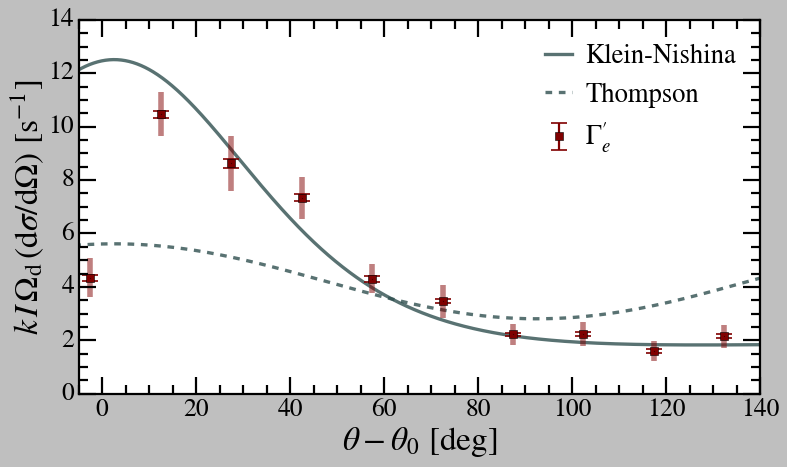

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

show_scattering_rate(compton_measurements,ax)

plt.tight_layout()
plt.savefig('report/Figures/scattering_rate.png')
plt.show()

In [ ]:
compton_measurements.electron_fwhm_rate/compton_measurements.electron_fwhm_rate_err

array([42.79977559, 76.35576474, 53.85830925, 55.57720093, 43.66119115,
       47.74415141, 33.61303395, 29.49100207, 23.85549017, 29.4607846 ])

In [ ]:
attenuation_metadata = {
    0 : ['0_0311.Spe','data/2025-03-11'],
    1 : ['1_0311.Spe','data/2025-03-11'],
    2 : ['2_0311.Spe','data/2025-03-11'],
    3 : ['3_0311.Spe','data/2025-03-11'],
    4 : ['4_0313.Spe','data/2025-03-13'],
    5 : ['5_0313.Spe','data/2025-03-13'],
    6 : ['6_0313.Spe','data/2025-03-13'],
    7 : ['7_0313.Spe','data/2025-03-13'],
}

material_thickness = {
    0 : 0,
    1 : 1.458,
    2 : 1.048,
    3 : 2.528,
    4 : 6.17,
    5 : 9.1,
    6 : 2.203,
    7 : 6.52
}

material_thickness_err = {
    0 : 0,
    1 : 0.014,
    2 : 0.008,
    3 : 0.03,
    4 : 0.13,
    5 : 0.4,
    6 : 0.021,
    7 : 0.14
}

material_thickness_err = np.array([material_thickness_err[angle] for angle in attenuation_metadata])

In [ ]:
attenuation_measurements = ComptonMeasurements(metadata=attenuation_metadata,
                                               detectors=['attenuation'],
                                               material_thickness=material_thickness,
                                               peak_idx=-1,thredshold_ratio=1/3)

100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


In [ ]:
class AttenuationFitter(fitting.BaseFitter):
    def __init__(self,thicknesses, count_rates,count_rates_err):
        super().__init__(thicknesses,count_rates,count_rates_err)

    def _get_initial_guess(self):
        return [1,0]
    
    def _get_model(self,x,params):
        A, k = params
        return A * np.exp(-k*x)
    
def show_attenuation(attenuation_measurements,ax):
    mass_to_number = 6.022e23 / (12 + 1) * 7 / 1e26 # convert to fm^2

    ax.errorbar(attenuation_measurements.thickness, attenuation_measurements.photon_fwhm_rate, xerr =material_thickness_err, yerr=attenuation_measurements.photon_fwhm_rate_err,
                fmt=' s', markersize=7.5, elinewidth=2, capsize=7.5, capthick=1.5, 
                color='royalblue',label=r'Experimental Data',zorder=-1)

    attenuation_fitter = AttenuationFitter(attenuation_measurements.thickness,attenuation_measurements.photon_fwhm_rate,attenuation_measurements.photon_fwhm_rate_err)
    fitting_result = attenuation_fitter.fit()
    print(fitting_result)
    reduced_chisqr = fitting_result["reduced_chisqr"]
    res_mu = fitting_result['params'][1]/mass_to_number
    res_mu_err = fitting_result['e_params'][1]/mass_to_number
    dense_thicknesses, dense_attenuations = attenuation_fitter.model_interpolation(params=fitting_result['params'])
    ax.plot(dense_thicknesses[dense_thicknesses>=0], dense_attenuations[dense_thicknesses>=0], color='black', linestyle='--', label=rf'Exponential Fit, $\sigma = ({res_mu:.1f}\pm{res_mu_err:.1f})$ fm$^2$, $\chi^2_r = {reduced_chisqr:.2f}$')

    ax.set_xlim(-0.2, 10)
    # ax.set_ylim(0, 420)

    ax.set_xlabel(r'$\rho\, l$ [g cm$^{-2}$]')
    ax.set_ylabel(r'$\Gamma$ [s$^{-1}$]')

    ax.text(0.05, 0.2, r'$\sigma_{\text{Thomson}}\approx66.5$ fm$^{-2}$', transform=ax.transAxes, fontsize=20, rotation=0, horizontalalignment='left', verticalalignment='center')
    
    ax.text(0.05, 0.1, r'$\sigma_{\text{Klein-Nishina}}\approx25.6$ fm$^{-2}$', transform=ax.transAxes, fontsize=20, rotation=0, horizontalalignment='left', verticalalignment='center')

    ax.legend(loc='upper right', frameon=False, fontsize=20, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

{'params': array([3.77233231e+02, 7.99574362e-02]), 'e_params': array([6.89554879e-01, 3.94405334e-04]), 'chisqr': 525.7238057608696, 'reduced_chisqr': 87.62063429347826, 'alpha': 0.0, 'cov': array([[4.75485930e-01, 2.11959610e-04],
       [2.11959610e-04, 1.55555568e-07]]), 'success': True, 'message': '`ftol` termination condition is satisfied.'}


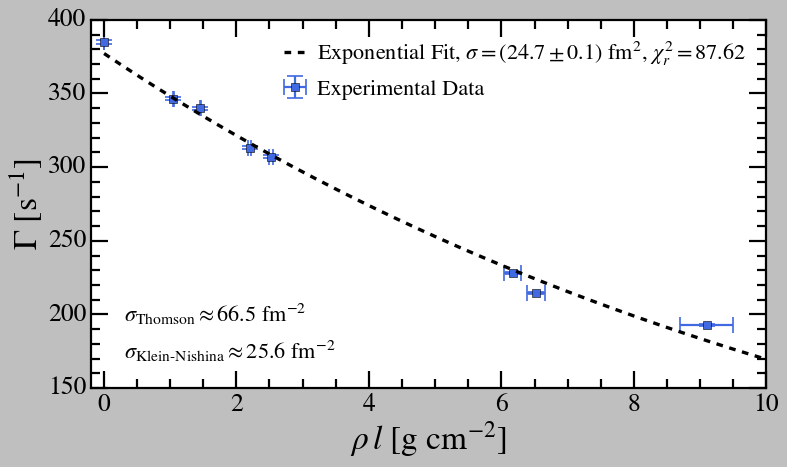

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# print(attenuation_measurements.photon_mu_energy)
# print(attenuation_measurements.photon_mu_energy_err)

show_attenuation(attenuation_measurements,ax)

plt.tight_layout()
plt.savefig('report/Figures/attenuation.png')

plt.show()

In [ ]:
import math

def kn_cross_section(E_keV):
    """
    Returns total Compton (Klein–Nishina) cross section in cm^2
    for a photon of energy E_keV.
    """
    # Electron rest mass-energy in keV
    m_e_c2 = 511.0
    
    # Classical electron radius in cm
    r_e = 2.8179403262e-13
    
    # Dimensionless parameter epsilon = E / (m_e c^2)
    eps = E_keV / m_e_c2
    
    # Break down the formula into parts:
    # (1) Factor out 2π r_e^2
    factor = 2.0 * math.pi * r_e**2
    
    # (2) Bracket terms
    termA = (1.0 + eps) / (eps**3)
    bracketA = (2.0 * eps * (1.0 + eps) / (1.0 + 2.0 * eps)) - math.log(1.0 + 2.0 * eps)
    
    termB = math.log(1.0 + 2.0 * eps) / (2.0 * eps)
    termC = - (1.0 + 3.0 * eps) / ((1.0 + 2.0 * eps)**2)
    
    # Sum the bracket
    bracket_sum = termA * bracketA + termB + termC
    
    # Final cross section
    sigma = factor * bracket_sum
    
    return sigma

# Example usage: compute at 661 keV
if __name__ == "__main__":
    E_test = 661.6
    sigma_val = kn_cross_section(E_test)
    print(f"KN cross section at {E_test} keV = {sigma_val:.4e} cm^2")

KN cross section at 661.6 keV = 2.5621e-25 cm^2
